# PUC Minas 
## Trabalho de Conclusão de Curso - <b>Inteligência Artificial e Aprendizado de Máquina</b>


- Autor: <b>Bruno Defante da Silva</b>

- Tema: <b>Modelo preditivo para inferência em paradas cardíacas</b>

- Conjunto de Dados: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)


Este notebook entra como parte fundamental na construção do trabalho de conclusão de curso, pois nele será desenvolvida toda a parte prática do trabalho.

O Projeto será desenvolvido utilizando a base de dados extraída do _Kaggle_ e poderá ser acessada no link disponibilizado acima.

<p> Aqui, serão importadas as biblíotecas necessárias:</p>

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from compose import PandasColumnTransformer
from utils import ProcessData
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Ingestão dos Dados

In [90]:
df = pd.read_csv('../data/heart.csv')

<b>Este tratamento serve apenas para deixar os nomes das colunas em caixa alta para facilitar o manuseio</b>

In [91]:
df.columns = [col.upper() for col in df.columns]

# Análise Univariada

In [92]:
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AGE             918 non-null    int64  
 1   SEX             918 non-null    object 
 2   CHESTPAINTYPE   918 non-null    object 
 3   RESTINGBP       918 non-null    int64  
 4   CHOLESTEROL     918 non-null    int64  
 5   FASTINGBS       918 non-null    int64  
 6   RESTINGECG      918 non-null    object 
 7   MAXHR           918 non-null    int64  
 8   EXERCISEANGINA  918 non-null    object 
 9   OLDPEAK         918 non-null    float64
 10  ST_SLOPE        918 non-null    object 
 11  HEARTDISEASE    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


Utilizando a função _info()_, é possível observar uma série de informações que serão úteis no decorrer de toda a análise

Possuímos no total 12 _features_, sendo elas:

- 5 variáveis categóricas

- 6 variáveis numéricas

- 1 target

<b>Não foi identificado nenhum valor nulo a ser tratado</b>

### Verificando Balenceamento da <b>Classe</b> alvo para modelagem

In [93]:
balance = df['HEARTDISEASE'].value_counts(normalize=True).round(2)
balance.index = balance.index.map({0:'Paciente Saúdavel', 1:'Parada Cardíaca'})
balance * 100

Parada Cardíaca      55.0
Paciente Saúdavel    45.0
Name: HEARTDISEASE, dtype: float64

Como podemos observar, as classes estão balanceadas, 

não necessitando de tratamentos como: <b>_Oversampling_</b> ou <b>_Undersampling_</b>


### Visão descritiva

Podemos utilizar a função _describe()_ para termos uma maior visão analítica dos dados

Como, por exemplo, os valores **mínimo**, **máximo** e os **percentis** de cada variável

In [94]:
df.describe()

,AGE,RESTINGBP,CHOLESTEROL,FASTINGBS,MAXHR,OLDPEAK,HEARTDISEASE
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [95]:
df.head()

,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Criação do Pipeline

Aqui, selecionamos as variáveis numéricas e categóricas

Esta parte será útil para Categorizar as <b>_Features_</b> dentro do <b>_Pipeline_</b> que será criado

In [96]:
cat_feat = df.select_dtypes(np.object_).columns.tolist()

num_feat = df.select_dtypes(np.number).columns.tolist()

Aqui será criado o _Pipeline_ que conterá os passos que serão utilizados para o <b>pré-processamento</b> dos dados

In [98]:
multi_class=list()
binary_class=list()
for col in df.select_dtypes(np.object_).columns:
    if len(df[col].value_counts().index) > 2:
        multi_class.append(col)
    else:
        binary_class.append(col)

In [99]:
df_tratado = pd.get_dummies(df, columns=multi_class, prefix=multi_class, prefix_sep='@')
for col in binary_class:
    df_tratado[col] = df_tratado[col].astype('category')
    df_tratado[col] = df_tratado[col].cat.codes

# Análise exploratória

In [102]:
df.head()

,AGE,SEX,CHESTPAINTYPE,RESTINGBP,CHOLESTEROL,FASTINGBS,RESTINGECG,MAXHR,EXERCISEANGINA,OLDPEAK,ST_SLOPE,HEARTDISEASE
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [103]:
plot_columns = df.select_dtypes(np.number).columns

## Distribuições

### Variáveis númericas

Podemos observar as distribuições das variáveis, ambas separadas pela variável alvo (HEARTDISEASE)

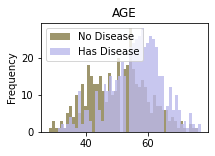

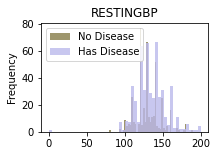

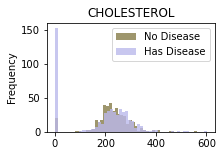

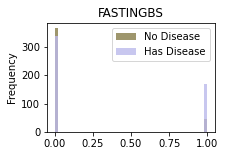

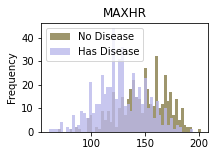

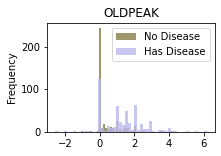

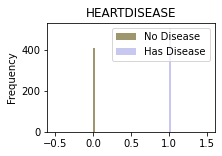

In [104]:
for col in plot_columns:
    plt.figure(figsize=(3,2))
    df.loc[df['HEARTDISEASE'] == 0, col].plot.hist(label='No Disease', color='#9E966D', bins=50)
    df.loc[df['HEARTDISEASE'] == 1, col].plot.hist(color='#BBB9EB', alpha=0.8, label='Has Disease', bins=50)
    plt.legend()
    plt.title(col)
    plt.show()    

### Variáveis Categóricas

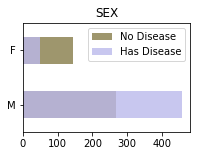

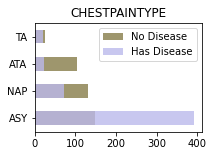

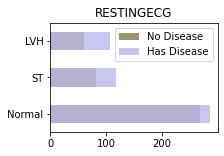

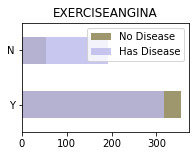

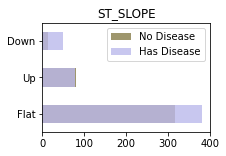

In [105]:
plot_columns = df.select_dtypes(np.object_).columns
for col in plot_columns:
    plt.figure(figsize=(3,2))
    mask = df['HEARTDISEASE'] == 1
    df.loc[~mask, col].value_counts().plot.barh(label='No Disease', color='#9E966D')
    df.loc[mask, col].value_counts().plot.barh(color='#BBB9EB', label='Has Disease', alpha=0.8)
    plt.legend()
    plt.title(col)
    plt.show()    

### Plots de Pares Gráficos de dispersão

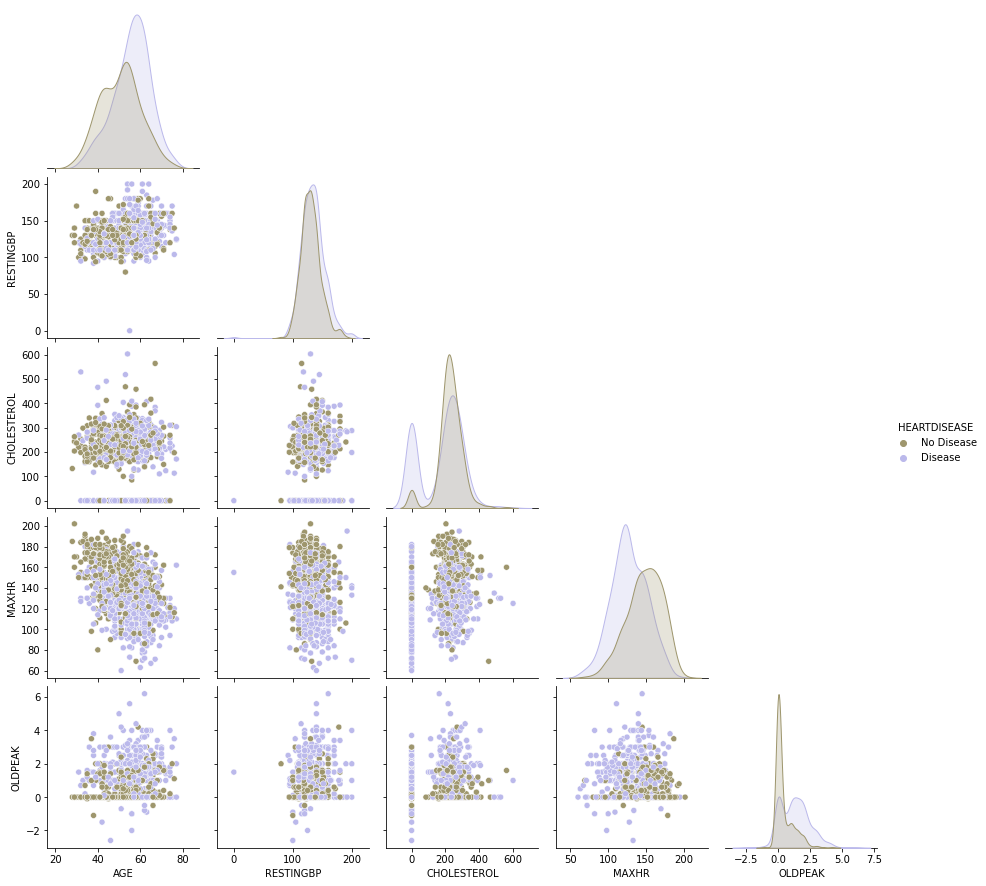

In [106]:
plot_df = df.copy()
plot_df['HEARTDISEASE'].rename({'0':'No Disease', '1':'Disease'})
plot_df['HEARTDISEASE']=plot_df['HEARTDISEASE'].map({0:'No Disease', 1:'Disease'})
img=sns.pairplot(vars=['AGE', 'RESTINGBP', 'CHOLESTEROL', 'MAXHR', 'OLDPEAK'], hue='HEARTDISEASE', data=plot_df, palette={'No Disease':'#9E966D', 'Disease':'#BBB9EB'}, corner=True)
plt.show()

### Mapa de calor - Correlação

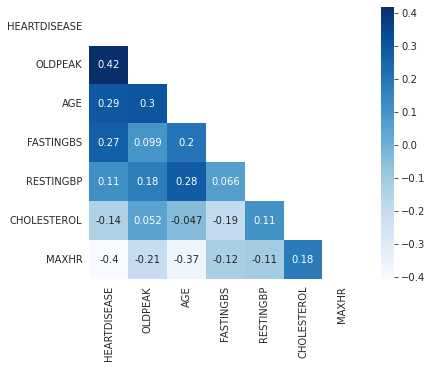

In [184]:
plot_columns = df.select_dtypes(np.number).columns
corr = df[plot_columns].corr(method='spearman')
order = corr['HEARTDISEASE'].sort_values(ascending=False).index
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr.loc[order, order], mask=mask, square=True, annot=True, cmap='Blues')
    # plt.title('Mapa de Calor - Correlação')

### Informação Mútua

In [108]:
from sklearn.feature_selection import mutual_info_classif

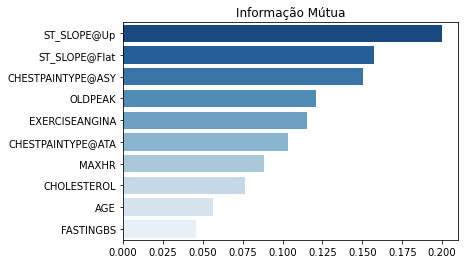

In [181]:
# plt.figure(figsize=(10,7))
X = df_tratado.drop('HEARTDISEASE', axis=1)
y = df_tratado['HEARTDISEASE']
mic = mutual_info_classif(X, y, n_neighbors=5)
mic = pd.Series(index=X.columns, data=mic)
mic.sort_values(ascending=False, inplace=True)
mic=mic[:10]
sns.barplot(y=mic.index, x=mic.values, palette='Blues_r')
plt.title('Informação Mútua')
plt.show()


### Verificação de outliers através dos gráficos BoxPlot (Método de Tukey)

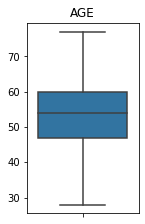

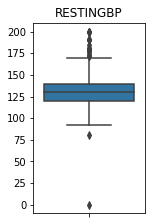

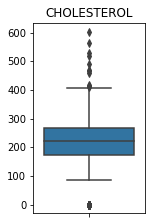

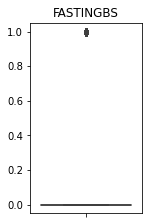

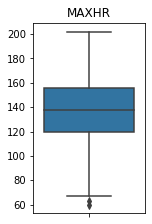

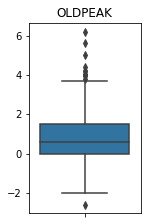

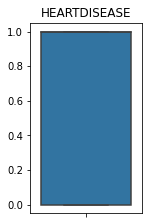

In [110]:
numeric_columns = df.select_dtypes(np.number).columns

for col in numeric_columns:
    plt.figure(figsize=(2,3.5))
    sns.boxplot(y=col, data=df)
    plt.title(col)
    plt.ylabel(None)
    plt.show()

### Visualização Probabílistica

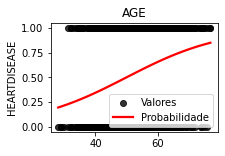

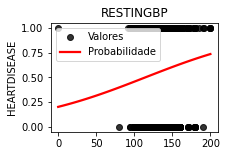

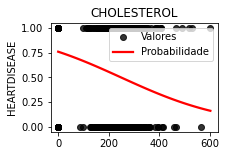

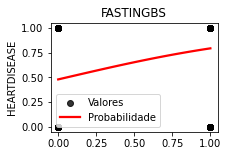

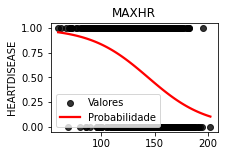

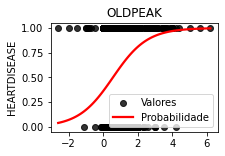

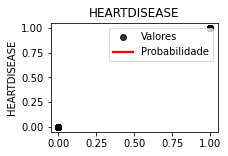

In [111]:
numeric_columns = df.select_dtypes(np.number).columns

for col in numeric_columns:
    plt.figure(figsize=(3,2))

    sns.regplot(x=col, y='HEARTDISEASE', data=df, logistic=True, ci=None, scatter_kws={'color':'black'}, line_kws={'color':'red', 'label':'Probabilidade'}, label='Valores')
    plt.legend()
    plt.title(col)
    plt.xlabel(None)
    plt.show()    

# Testes de Hipóteses

## Teste de Normalidade: <i>Kolmogorov-Smirnov</i>

In [112]:
from scipy.stats import kstest
from scipy import stats

numeric_columns = df_tratado.select_dtypes(np.number).columns
for col in numeric_columns:
    pvalue = kstest(df[col], stats.norm.cdf).pvalue

    print('-'*10)
    print('Variável a ser testada:', col)

    if pvalue < 0.05:
        print('Hipótese H0 rejeitada!')
        print('Variável não possui distribuição normal!')
    else:
        print('Hipótese H0 Aceita!')
        print('Variável possui distribuição normal!')

    print('P_value do teste:', pvalue)    

----------
Variável a ser testada: AGE
Hipótese H0 rejeitada!
Variável não possui distribuição normal!
P_value do teste: 0.0
----------
Variável a ser testada: RESTINGBP
Hipótese H0 rejeitada!
Variável não possui distribuição normal!
P_value do teste: 0.0
----------
Variável a ser testada: CHOLESTEROL
Hipótese H0 rejeitada!
Variável não possui distribuição normal!
P_value do teste: 0.0
----------
Variável a ser testada: FASTINGBS
Hipótese H0 rejeitada!
Variável não possui distribuição normal!
P_value do teste: 9.62555011802948e-213
----------
Variável a ser testada: MAXHR
Hipótese H0 rejeitada!
Variável não possui distribuição normal!
P_value do teste: 0.0
----------
Variável a ser testada: OLDPEAK
Hipótese H0 rejeitada!
Variável não possui distribuição normal!
P_value do teste: 4.2004655072318036e-200
----------
Variável a ser testada: HEARTDISEASE
Hipótese H0 rejeitada!
Variável não possui distribuição normal!
P_value do teste: 9.62555011802948e-213


## Teste de tendência central: <i>Mann-Whitney</i>

In [113]:
from scipy.stats import mannwhitneyu

numeric_columns = df.select_dtypes(np.number).columns
for col in numeric_columns:
    mask = df['HEARTDISEASE'] == 1
    grupo_positivo = df.loc[mask, col]
    grupo_negativo = df.loc[~mask, col]

    pvalue = mannwhitneyu(grupo_positivo, grupo_negativo).pvalue

    print('-'*10)
    print('Variável a ser testada:', col)
    
    if pvalue < 0.05:
        print('Hipótese H0 rejeitada!')
        print('Amostras semelhantes!')
    else:
        print('Hipótese H0 Aceita!')
        print('Amostras diferentes!')

    print('P_value do teste:', pvalue)    

----------
Variável a ser testada: AGE
Hipótese H0 rejeitada!
Amostras semelhantes!
P_value do teste: 1.805694139029245e-18
----------
Variável a ser testada: RESTINGBP
Hipótese H0 rejeitada!
Amostras semelhantes!
P_value do teste: 0.0005648075493721535
----------
Variável a ser testada: CHOLESTEROL
Hipótese H0 rejeitada!
Amostras semelhantes!
P_value do teste: 2.2803123635449238e-05
----------
Variável a ser testada: FASTINGBS
Hipótese H0 rejeitada!
Amostras semelhantes!
P_value do teste: 5.776379942652706e-16
----------
Variável a ser testada: MAXHR
Hipótese H0 rejeitada!
Amostras semelhantes!
P_value do teste: 1.5063588719598379e-34
----------
Variável a ser testada: OLDPEAK
Hipótese H0 rejeitada!
Amostras semelhantes!
P_value do teste: 6.767845043438792e-37
----------
Variável a ser testada: HEARTDISEASE
Hipótese H0 rejeitada!
Amostras semelhantes!
P_value do teste: 1.986905801438512e-201


## Teste de associações: <i>Qui-Quadrado</i>

In [173]:
from scipy.stats import chi2_contingency

hot_encoded = [col for col in df_tratado.columns if '@' in col]
for col in hot_encoded + binary_class:
    
    ctab = pd.crosstab(df_tratado[col], df_tratado['HEARTDISEASE'])
    _, pvalue, _, _ = chi2_contingency(ctab)

    print('-'*10) 
    print('Variável a ser testada:', col)    
    if pvalue < 0.05:
        print('Hipótese H0 rejeitada!')
        print('Há associação entre os grupos!')
    else:
        print('Hipótese H0 Aceita!')
        print('Não há associação entre os grupos!')

    print('P_value do teste:', pvalue)

----------
Variável a ser testada: CHESTPAINTYPE@ASY
Hipótese H0 rejeitada!
Há associação entre os grupos!
P_value do teste: 8.629373889117524e-55
----------
Variável a ser testada: CHESTPAINTYPE@ATA
Hipótese H0 rejeitada!
Há associação entre os grupos!
P_value do teste: 1.1525973044710746e-33
----------
Variável a ser testada: CHESTPAINTYPE@NAP
Hipótese H0 rejeitada!
Há associação entre os grupos!
P_value do teste: 1.8597575246926209e-10
----------
Variável a ser testada: CHESTPAINTYPE@TA
Hipótese H0 Aceita!
Não há associação entre os grupos!
P_value do teste: 0.13157675122814316
----------
Variável a ser testada: RESTINGECG@LVH
Hipótese H0 Aceita!
Não há associação entre os grupos!
P_value do teste: 0.8095282584405754
----------
Variável a ser testada: RESTINGECG@Normal
Hipótese H0 rejeitada!
Há associação entre os grupos!
P_value do teste: 0.006790624252570402
----------
Variável a ser testada: RESTINGECG@ST
Hipótese H0 rejeitada!
Há associação entre os grupos!
P_value do teste: 0.0

# Preparação dos dados

### Separação entre Treino e Teste

In [148]:
from sklearn.model_selection import train_test_split
X = df.drop(columns='HEARTDISEASE')
y = df['HEARTDISEASE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Criação da configuração de tratamento de outliers

In [129]:
trans_columns = {
                    'CHOLESTEROL':{
                        'limit_inf':np.mean, 
                        'limit_sup':None
                    },
                    'RESTINGBP':{
                        'limit_inf':np.mean, 
                        'limit_sup':None
                    }
                }





### Criação do pipeline para preparação dos dados

In [145]:
preprocess=Pipeline([
    ('procdata', ProcessData(trans_columns=trans_columns, 
                    clean_inf=True, 
                    clean_sup=False, 
                    outliers_value='Tukey')),
    ('ct', ColumnTransformer([
        ('onehot', OneHotEncoder(), cat_feat)
    ],
    remainder='passthrough'),
    )
])

### Verificação do balanceamento entre classes

In [ ]:
import plotly.express as px
plot_ = df['HEARTDISEASE'].map({1:'Disease', 0:'No Disease'}).value_counts().reset_index()
fig = px.bar(plot_, 
        x='index', 
        y='HEARTDISEASE',
        labels={'index':'Classes', 'HEARTDISEASE':''},
        title='Balanceamente de Classes',
        width=600)
fig.update_xaxes(type='category')
fig.show()
